### **Example of retrospective target inference (RTI)**

We 

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np


import sys
sys.path.append('../utils/plotting/')
sys.path.append('../utils/PD_tools/')
sys.path.append('../utils/simulation/')
sys.path.append('../utils/recalibration/')
sys.path.append('../utils/preprocessing/')
from plotting_utils import figSize
from simulation import *
from simulation_utils import * 


# for a reproducible result
np.random.seed(1)


In [2]:
import matplotlib.pyplot as plt
from sklearn.decomposition import FactorAnalysis
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from CosineTuning import getAngles
import matplotlib.cm as cm


#The first column of cursorTuning is the means, and the second two columns are the preferred directions. 
nUnits         = 192
SNR            = 0.5
nTrainingSteps = 10000

cursorTuning   = generateUnits(n_units = nUnits, SNR = SNR)
clickTuning    = orthogonalizeAgainst(np.random.normal(size = (192,)), cursorTuning[:, 1])
clickTuning    = orthogonalizeAgainst(clickTuning / np.linalg.norm(clickTuning), cursorTuning[:, 2])[:, np.newaxis] 


calNeural, calVelocity = simulateUnitActivity(cursorTuning, noise = 0.3, nSteps = nTrainingSteps)
lr                     = LinearRegression(fit_intercept = True).fit(calNeural, calVelocity)
D                      = np.hstack([lr.intercept_[:, np.newaxis], lr.coef_]).T

# Normalize the gain of this decoder so that it will output vectors with a magnitude of 1 when the encoded velocity has a magnitude of 1. 
D[:, 0] = D[:,0] / np.linalg.norm(D[1:, :][:, 0]) / np.linalg.norm(cursorTuning[:, 1])
D[:, 1] = D[:,1] / np.linalg.norm(D[1:, :][:, 1]) / np.linalg.norm(cursorTuning[:, 2])

In [3]:
alpha       = 0.94 # amount of exponential smoothing (0.9 to 0.96 are reasonable)
delT        = 0.01 # define the time step (10 ms)
nDelaySteps = 20   # define the simulated user's visual feedback delay (200 ms)


# Do a quick sweep of cursor gains to find the optimal one for this task:

import matplotlib.pyplot as plt 
figSize(5,5)

possibleGain = np.linspace(0.5,2.5,10)
nSimSteps    = 50000
meanTTT      = np.zeros((len(possibleGain),))

for g in range(len(possibleGain)):
    print(str(g) + ' / ' + str(len(possibleGain)))
    posTraj, velTraj, rawDecTraj, conTraj, targTraj, neuralTraj, trialStart, ttt = simulateBCIFitts(cursorTuning, D, alpha, possibleGain[g], nDelaySteps, delT, nSimSteps)
    meanTTT[g] = np.mean(ttt)

minIdx = np.argmin(meanTTT)
beta   = possibleGain[minIdx]

print('Using gain value beta = ', beta)

0 / 10


../utils/simulation\simulation.py:143: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  simAct  = neuralTuning[:,1:].dot(currControl)
../utils/simulation\simulation.py:148: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  rawDecVec = np.dot(D[1:,:].T, simAct)


1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
Using gain value beta =  1.3888888888888888


In [4]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression

PCA_nComponents = 4


# simulate some open loop click data - target dwell logic is used to move to next trial
D_click = None

posTraj, velTraj, rawDecTraj, _, _, conTraj, targTraj, neuralTraj, trialStart, ttt = simulateBCIFitts_click(cursorTuning, clickTuning, D, D_click, alpha, beta, nDelaySteps, delT, nSimSteps, ClickLogic = False)

targets = np.zeros((len(neuralTraj),))
for t in trialStart:
    targets[(t - 25):t] = 1
    
decoder         = Pipeline([('PCA', PCA(n_components = PCA_nComponents)), ('Logistic', LogisticRegression(class_weight = 'balanced', max_iter = 3000))])
decoder.fit(X = neuralTraj, y = targets)

Pipeline(steps=[('PCA', PCA(n_components=4)),
                ('Logistic',
                 LogisticRegression(class_weight='balanced', max_iter=3000))])

In [35]:
# Simulate BCI performance with matched neural tuning and decoder, and an optimized gain
D_click      = [decoder, 0.7]
PD_shrinkage = 0.5
nSimSteps    = 10000

posTraj, velTraj, rawDecTraj, clickMagTraj, clickTraj, conTraj, targTraj, neuralTraj, trialStart, ttt = simulateBCIFitts_click(cursorTuning, clickTuning, D, D_click, alpha, beta, nDelaySteps, delT, nSimSteps, ClickLogic = True)                                   
print('With a matched, optimized decoder, mean trial time is ', np.mean(ttt), ' s')

# Simulate a change in neural cursor tuning (specifically, change the PDs only, making sure the total magnitude of tuning is the same)
newCursorTuning = simulateTuningShift(cursorTuning, PD_shrinkage = PD_shrinkage)
posTraj_new, velTraj_new, rawDecTraj_new, clickMagTraj_new, clickTraj_new, conTraj_new, targTraj_new, neuralTraj_new, trialStart_new, ttt_new = simulateBCIFitts_click(newCursorTuning, clickTuning, D, D_click, alpha, beta, nDelaySteps, delT, nSimSteps, ClickLogic = True)
print('With changed tuning and a mismatched decoder, the mean trial time is ', np.mean(ttt_new), ' s')

#Control: increase gain in original tuning subspace 
posTraj_control, velTraj_control, rawDecTraj_control, clickMagTraj_control, clickTraj_control, conTraj_control, targTraj_control, neuralTraj_control, trialStart_control, ttt_control = simulateBCIFitts_click(newCursorTuning, clickTuning, D, D_click, alpha, beta / PD_shrinkage, nDelaySteps, delT, nSimSteps, ClickLogic = True)
print('Control: With changed tuning and a mismatched decoder with restored gain, the mean trial time is ', np.mean(ttt_control), ' s')

With a matched, optimized decoder, mean trial time is  1.0049494949494948  s
With changed tuning and a mismatched decoder, the mean trial time is  1.215679012345679  s
Control: With changed tuning and a mismatched decoder with restored gain, the mean trial time is  1.2428750000000002  s


Now use RTI to recalibrate

In [37]:
from RTI_utils import get_RTIData

lookback = 120     # look this many timesteps prior to click for training data
minDist  = 0.0     # exclude time points that are too close to target (noisy)
onTarget = (np.linalg.norm(posTraj_new - targTraj_new, axis = 1) < 0.075).astype('int') 

x, y     = get_RTIData(neuralTraj_new, posTraj_new, clickTraj_new.squeeze(), onTarget, lookback, minDist)

print(x.shape)

(120, 192)


(12, 2)

Now modify our original decoder to use the new factor analysis model and stabilizing transformation:

In [22]:
G_new     = get_FactorAnalysisMap(stab.new_model)
D_coefnew = h.dot(G_new.dot(stab.R).T)                                # compose to get neural --> latent --> output 
D_new     = np.hstack([lr.intercept_[:, np.newaxis], D_coefnew]).T    # add bias terms

# Normalize the gain of this decoder so that it will output vectors with a magnitude of 1 when the encoded velocity has a magnitude of 1. 
D_new[:, 0] = D_new[:,0] / np.linalg.norm(D_new[1:, :][:, 0]) / np.linalg.norm(newTuning[:, 1])
D_new[:, 1] = D_new[:,1] / np.linalg.norm(D_new[1:, :][:, 1]) / np.linalg.norm(newTuning[:, 2])

Text(0.5, 1.0, 'Time to target with simulated PD shift')

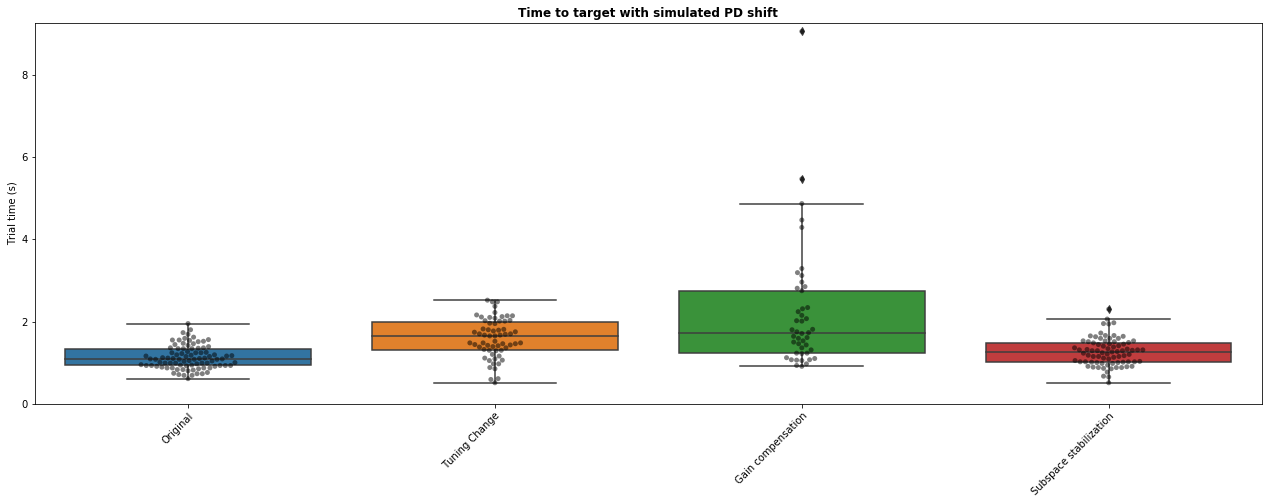

In [24]:
'''
Summarize the performance for all 4 relevant conditions: original performance, performance when the tuning changes (but the decoder
doesn't), performance with the HMM-powered unsupervised recalibration, and performance with supervised recalibration. 
We plot means and 95% CIs.
'''
from scipy.stats import norm
import seaborn as sns

groups = [ttt, ttt_new, ttt_control, ttt_ss]

sns.boxplot(data = groups)
sns.swarmplot(data = groups, color = 'k', alpha = 0.5)

ax = plt.gca()
labels = ['Original','Tuning Change','Gain compensation', 'Subspace stabilization']
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.ylabel('Trial time (s)')
plt.ylim([0, max([max(i) for i in groups]) + 0.2])
plt.title('Time to target with simulated PD shift', fontweight = 'bold')